In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams.update({'font.size': 16})

import numpy as np

import reference_LFs as refLF
from paus_utils import *

from jpasLAEs.utils import bin_centers

import numpy as np

In [2]:
def load_combined_LF(region_list, nb1, nb2):
    this_hist = None
    for kk, region_name in enumerate(region_list):
        LF_name = f'Lya_LF_nb{nb1}-{nb2}_{region_name}'
        pathname = f'/home/alberto/almacen/PAUS_data/Lya_LFs/{LF_name}'
        filename_hist = f'{pathname}/hist_i_mat_{region_name}.npy'

        # TODO: PROVISIONAL. As long as we are testing the mocks, weight
        # the contributions by the mock area
        area_dict = {
            'SFG': 400,
            'QSO_cont': 200,
            'QSO_LAEs_loL': 400,
            'QSO_LAEs_hiL': 4000,
            'GAL': 59.97 * 0.3
        }
        this_scale_factor = area_dict['QSO_LAEs_loL'] / area_dict[region_name]
        hist_i_mat = np.load(filename_hist) * this_scale_factor

        if this_hist is None:
            this_hist = hist_i_mat
        else:
            this_hist += hist_i_mat

    eff_vol = Lya_effective_volume(nb1, nb2, 'QSO_LAEs_loL')

    L_bins = np.load(f'{pathname}/LF_L_bins.npy')
    bin_width = [L_bins[i + 1] - L_bins[i] for i in range(len(L_bins) - 1)]

    L_LF_err_percentiles = np.percentile(this_hist, [16, 50, 84], axis=0)
    hist_median = L_LF_err_percentiles[1]

    boots_path = f'/home/alberto/almacen/PAUS_data/Lya_LFs/bootstrap_errors'
    yerr_minus = np.load(f'{boots_path}/LF_err_minus_nb{nb1}-{nb2}.npy')
    yerr_plus = np.load(f'{boots_path}/LF_err_plus_nb{nb1}-{nb2}.npy')

    this_LF = hist_median / bin_width / eff_vol
    LF_boots = np.load(f'{boots_path}/median_LF_nb{nb1}-{nb2}.npy')
    # Fix yerr_minus when LF_boots == 0
    yerr_minus[LF_boots == 0] = this_LF[LF_boots == 0]

    this_LF_dict = {
        'LF_bins': bin_centers(L_bins),
        'LF_total': this_LF,
        'LF_total_err': [yerr_minus, yerr_plus],
    }

    return this_LF_dict

In [3]:
# Load the QSO mock to compare
from load_paus_mocks import load_qso_mock
from jpasLAEs.utils import flux_to_mag

source_cats_dir = '/home/alberto/almacen/Source_cats'
mock_path = f'{source_cats_dir}/QSO_PAUS_LAES_2'
mock = load_qso_mock(mock_path)

mock['r_mag'] = flux_to_mag(mock['flx_0'][-4], w_central[-4])

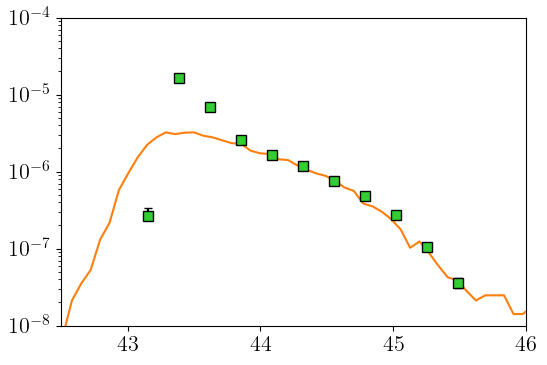

In [5]:
survey_list = ['SFG', 'QSO_cont', 'QSO_LAEs_loL',
               'GAL']

nb1, nb2 = 1, 10

LyaLF = load_combined_LF(survey_list, nb1, nb2)

# LF of the mock
L_bins = np.linspace(40, 47, 100)
L_bins_c = bin_centers(L_bins)
L_bins_w = L_bins[1] - L_bins[0]
mask_mock = ((NB_z(mock['zspec']) >= nb1)
             & (NB_z(mock['zspec']) <= nb2)
             & (mock['EW0_lya_spec'] > 30)
             & (mock['r_mag'] < 24)
             & (mock['r_mag'] > 17))
mock_LF = np.histogram(mock['L_lya_spec'][mask_mock], L_bins)[0]\
              / L_bins_w / Lya_effective_volume(nb1, nb2, 400)


fig, ax = plt.subplots(figsize=(6, 4))

ax.errorbar(LyaLF['LF_bins'], LyaLF['LF_total'],
            yerr=LyaLF['LF_total_err'],
            fmt='s', ls='', mfc='limegreen', mec='k',
            ms=7, ecolor='k', capsize=3)

ax.plot(L_bins_c, mock_LF)

ax.set(yscale='log',
       xlim=(42.5, 46), ylim=(1e-8, 1e-4))

plt.show()